Softmax与交叉熵损失
===

# 1.线性分类器
假设现在我们有一张2×2×1的图像(即图像大小为2×2，通道数为1)，像素值是$\begin{bmatrix}
56&231 \\
24&2
\end{bmatrix}$,此时我们构建一个线性分类期去判断该幅图像属于哪一种类别
![images](Images/13_03_001.png)

用一张图表示就是

![images](Images/13_03_002.png)

此时增加一下难度，如果我们的训练数据是64×64×3的RGB图像呢？同理，这时我们的$x$就是一个$12288 \times 1$的向量$64 \times 64 \times 3=12288$

![images](Images/13_03_003.png)

模型的参数可以通过最小化损失函数来获得

# 2.Sigmoid与Softmax的区别与联系
如果使用线性回归模型进行分类的话，得到的是一个具体的数值，并不直观。我们更希望可以直接得到某一样本属于各个类别的概率。对于二分类任务来说，我们可以采用对数几率回归来输出样本属于正类的概率。那么对于多分类该怎么办呢？答案就是softmax分类器。

## 2.1.Sigmoid函数
Sigmoid函数在[逻辑回归](03.逻辑回归.ipynb)中已经介绍过了，它的形式是
$$S(x)=\frac{1}{1+e^{-x}}$$
Sigmoid是一个可微的有界函数，在各点均有非负的导数。当$𝑥 \to \infty$时，$𝑆(𝑥) \to 1$;当 $𝑥 \to -\infty$时，$𝑆(𝑥) \to 0$。常用于二元分类(Binary Classification)问题，以及神经网络的激活函数(Activation Function)(把线性的输入转换为非线性的输出)。

## 2.2.Softmax函数
Softmax主要用于多分类以及神经网络的概率输出。它的形式如下：
$$\sigma_i(Z)=\frac{e^{z_i}}{\sum_{k=1}^Ke^{z_k}}, j=1,2,...,K$$
![image](Images/13_03_004.jpg)

对于一个长度为$K$的任意实数矢量，Softmax可以把它压缩为一个长度为$K$的、取值在$(0, 1)$区间的实数矢量，且矢量中各元素之和为$1$。它在多元分类(Multiclass Classification)和神经网络中也有很多应用。Softmax不同于普通的 $max$函数：$max$函数只输出最大的那个值，而Softmax则确保较小的值也有较小的概率，不会被直接舍弃掉，是一个比较"Soft"的"max"。

In [1]:
import numpy as np
prediction = np.array([0.02760797,-0.00083022,0.00351067,-0.00328555,0.00372311,-0.00814351,-0.00122638,-0.00717432,0.00035223,0.00667405])
prediction = np.reshape(prediction, newshape=(1, 10))
exp_prediction = np.zeros(prediction.shape)
softmax = np.zeros(prediction.shape)
for i in range(prediction.shape[0]):
    prediction[i, :] -= np.max(prediction[i, :])
    exp_prediction[i] = np.exp(prediction[i])
    softmax[i] = exp_prediction[i]/np.sum(exp_prediction[i])
print(softmax)

[[0.10257674 0.09970073 0.10013446 0.09945623 0.10015573 0.09897425
  0.09966124 0.09907022 0.09981869 0.10045172]]


上述算法实现了Softmax的过程。prediction是神经网络预测出来的当前图片所对应的分类的概率。我们将prediction里面的每个值都减去分类概率的最大值，这样并不会影响最终的结果，但是却能使得我们计算exp时遇到上下溢的情况后表现的更为正常。这是因为对一个比较大的数求exponential非常容易发生overflow。求exponential之前将$z$的每一个元素减去$z_i$的最大值。这样求exponential的时候会碰到的最大的数就是0了，不会发生overflow的问题，但是如果其他数原本是正常范围，现在全部被减去了一个非常大的数，于是都变成了绝对值非常大的负数，所以全部都会发生underflow，但是underflow的时候得到的是0，这其实是非常meaningful的近似值，而且后续的计算也不会出现奇怪的NaN.最关键的是最后我们一般都会做normalization，所以同时减去一个任意数是不会改变最终的预测的


## 2.3.Sigmoid和Softmax的关系

对于Sigmoid来说，有
$$
\begin{split}
p(y=1|x)&=\frac{1}{1+e^{-\theta^Tx}} \\
p(y=0|x)&=1-p(y=1|x)=\frac{e^{-\theta^Tx}}{1+e^{-\theta^Tx}}
\end{split}
$$

对于$K=2$的Softmax来说，有
$$
\begin{split}
p(y=1|x)&=\frac{e^{\theta_1^Tx}}{e^{\theta_0^Tx}+e^{\theta_1^Tx}}=\frac{1}{1+e^{(\theta_0^T – \theta_1^T)x}}=\frac{1}{1+e^{-\beta x}} \\
p(y=0|x)&=\frac{e^{\theta_0^Tx}}{e^{\theta_0^Tx}+e^{\theta_1^Tx}}=\frac{e^{(\theta_0^T-\theta_1^T)x}}{1+e^{(\theta_0^T-\theta_1^T)x}}=\frac{e^{-\beta x}}{1+e^{-\beta x}} 
\end{split}
$$
其中$\beta=-(\theta_0^T-\theta_1^T)$,可见在二元分类的情况下，Softmax退化为了Sigmoid。

# 3.使用分类错误率与均方误差来解决分类问题

## 3.1.例子
根据一个人的年龄、性别、年收入等相互独立的特征，来预测一个人的政治倾向，有三种可预测结果：民主党、共和党、其他党。假设我们当前有两个逻辑回归模型（参数不同），这两个模型都是通过sigmoid的方式得到对于每个预测结果的概率值

模型一

| COMPUTED | TARGETS | CORRECT |
| -------- | ------- | ------- |
| 0.3 0.3 0.4 | 0 0 1(民主党) | 正确 |
| 0.3 0.4 0.3 | 0 1 0(共和党) | 正确 |
| 0.1 0.2 0.7 | 1 0 0(其它党) | 错误 |

模型二

| COMPUTED | TARGETS | CORRECT |
| -------- | ------- | ------- |
| 0.1 0.2 0.7 | 0 0 1(民主党) | 正确 |
| 0.1 0.7 0.2 | 0 1 0(共和党) | 正确 |
| 0.3 0.4 0.3 | 1 0 0(其它党) | 错误 |

## 3.2.分类错误率
$$\text{分类错误率}=\frac{\text{错误的数量}}{\text{总样本数量}}$$
模型一的分类错误率是$\frac{1}{3}$，模型二的分类错误率也是$\frac{1}{3}$。我们知道，模型1和模型2虽然都是预测错了1个，但是相对来说模型2表现得更好，损失函数值照理来说应该更小，但是，很遗憾的是，分类错误率并不能判断出来，所以这种损失函数虽然好理解，但表现不太好。

## 3.3.均方误差-Mean Squared Error
$$MSE=\frac{1}{n}\sum_i^n(\hat{y_i}-y_i)^2$$

模型一
$$
\begin{split}
L_1&=\frac{(0.3-0)^2+(0.3-0)^2+(0.4-1)^2}{3}=0.18 \\
L_2&=\frac{(0.3-0)^2+(0.4-1)^2+(0.3-0)^2}{3}=0.18 \\
L_3&=\frac{(0.1-1)^2+(0.2-0)^2+(0.7-0)^2}{3}=0.44 \\
\end{split}
$$
所有样本的loss平均为
$$MSE=\frac{0.18+0.18+0.44}{3}=0.26$$

模型二
$$
\begin{split}
L_1&=\frac{(0.1-0)^2+(0.2-0)^2+(0.7-1)^2}{3}=0.046 \\
L_2&=\frac{(0.1-0)^2+(0.7-1)^2+(0.2-0)^2}{3}=0.046 \\
L_3&=\frac{(0.3-1)^2+(0.4-0)^2+(0.3-0)^2}{3}=0.240 \\
\end{split}
$$
所有样本的loss平均为
$$MSE=\frac{0.046+0.046+0.24}{3}=0.11$$

MSE能够判断出来模型2优于模型1，那为什么不采样这种损失函数呢？主要原因是逻辑回归配合MSE损失函数时，采用梯度下降法进行学习时，会出现模型一开始训练时，学习速率非常慢的情况。有了上面的直观分析，我们可以清楚的看到，对于分类问题的损失函数来说，分类错误率和均方误差损失都不是很好的损失函数

# 4.交叉熵损失函数
$$H_p(q)=\sum_xq(x)ln\frac{1}{p(x)}$$
$q(x)$是真实分布，$p(x)$是预测分布

## 4.1.二分类
在二分的情况下，模型最后需要预测的结果只有两种情况，对于每个类别我们的预测得到的概率为$p$和$1-p$，有
$$
\begin{split}
H_p(q)&=\sum_xq(x)ln\frac{1}{p(x)} \\
&=q(x_1)ln\frac{1}{p(x_1)} + q(x_2)ln\frac{1}{p(x_2)} \\
&=-q(x_1)lnp(x_1)-q(x_2)lnp(x_2) \\
&=-[q(x_1)lnp(x_1)+q(x_2)log_2p(x_2)] \\
&=-[q(x_1)lnp+q(x_2)ln(1-p)] \\
&=-[ylnp+(1-y)ln(1-p)]
\end{split}
$$
其中y是样本的label，正类为1，负类为0

## 4.2.多分类
多分类就是使用的原始的公式

## 4.3.使用交叉熵损失来计算例子

模型一
$$
\begin{split}
L_1&=-(0 \times log_e{0.3} + 0 \times log_e{0.3} + 1 \times log_e{0.4})=0.91 \\
L_2&=-(0 \times log_e{0.3} + 1 \times log_e{0.4} + 0 \times log_e{0.3})=0.91 \\
L_3&=-(1 \times log_e{0.1} + 0 \times log_e{0.2} + 0 \times log_e{0.7})=2.30 \\
\end{split}
$$
求平均之后是
$$MSE=\frac{0.91+0.91+2.3}{3}=1.37$$

模型二
$$
\begin{split}
L_1&=-(0 \times log_e{0.1} + 0 \times log_e{0.2} + 1 \times log_e{0.7})=0.35 \\
L_2&=-(0 \times log_e{0.1} + 1 \times log_e{0.7} + 0 \times log_e{0.2})=0.35 \\
L_3&=-(1 \times log_e{0.3} + 0 \times log_e{0.4} + 0 \times log_e{0.4})=1.20 \\
\end{split}
$$
求平均之后是
$$MSE=\frac{0.35+0.35+1.2}{3}=0.63$$

可以发现，交叉熵损失函数可以捕捉到模型1和模型2预测效果的差异。

## 4.4.学习过程
由于交叉熵涉及到计算每个类别的概率，所以交叉熵几乎每次都和sigmoid(或softmax)函数一起出现。
- 神经网络最后一层得到每个类别的得分scores；
- 该得分经过sigmoid(或softmax)函数获得概率输出；
- 模型预测的类别概率输出与真实类别的one hot形式进行交叉熵损失函数的计算。

# 5.Softmax回归实例

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

Sebastian Raschka 

CPython 3.6.10
IPython 7.12.0

torch 1.3.1


## 5.1.导入数据集

In [2]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 123
learning_rate = 0.1
num_epochs = 10
batch_size = 256
num_features = 784
num_classes = 10

train_dataset = datasets.MNIST(root='/Users/JJZHK/data/input/', 
                               train=True, 
                               transform=transforms.ToTensor(),  
                               download=False)

test_dataset = datasets.MNIST(root='/Users/JJZHK/data/input/', 
                              train=False, 
                              transform=transforms.ToTensor(),
                              download=False)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


## 5.2.定义模型

In [3]:
class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

## 5.3.训练

In [4]:
# Manual seed for deterministic data loader
torch.manual_seed(random_seed)

def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
    

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        # note that the PyTorch implementation of
        # CrossEntropyLoss works with logits, not
        # probabilities
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))
            
    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

Epoch: 001/010 | Batch 000/234 | Cost: 2.3026
Epoch: 001/010 | Batch 050/234 | Cost: 0.7941
Epoch: 001/010 | Batch 100/234 | Cost: 0.5651
Epoch: 001/010 | Batch 150/234 | Cost: 0.4603
Epoch: 001/010 | Batch 200/234 | Cost: 0.4822
Epoch: 001/010 training accuracy: 88.04%
Epoch: 002/010 | Batch 000/234 | Cost: 0.4105
Epoch: 002/010 | Batch 050/234 | Cost: 0.4415
Epoch: 002/010 | Batch 100/234 | Cost: 0.4367
Epoch: 002/010 | Batch 150/234 | Cost: 0.4289
Epoch: 002/010 | Batch 200/234 | Cost: 0.3926
Epoch: 002/010 training accuracy: 89.37%
Epoch: 003/010 | Batch 000/234 | Cost: 0.4112
Epoch: 003/010 | Batch 050/234 | Cost: 0.3579
Epoch: 003/010 | Batch 100/234 | Cost: 0.3013
Epoch: 003/010 | Batch 150/234 | Cost: 0.3258
Epoch: 003/010 | Batch 200/234 | Cost: 0.4254
Epoch: 003/010 training accuracy: 89.98%
Epoch: 004/010 | Batch 000/234 | Cost: 0.3988
Epoch: 004/010 | Batch 050/234 | Cost: 0.3690
Epoch: 004/010 | Batch 100/234 | Cost: 0.3459
Epoch: 004/010 | Batch 150/234 | Cost: 0.4030
Epo

In [5]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 91.77%


# 6.使用Softmax对鸢尾花数据进行分类

In [6]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## 6.1.导入数据

In [7]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 0
learning_rate = 0.05
num_epochs = 10
batch_size = 8

# Architecture
num_features = 2
num_classes = 3

data = np.genfromtxt('data/iris.data', delimiter=',', dtype=str)
X, y = data[:, [2, 3]], data[:, 4]
X = X.astype(float)

d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
y = np.array([d[x] for x in y])
y = y.astype(np.int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [50 50 50]
X.shape: (150, 2)
y.shape: (150,)


In [8]:
class MyDataset(Dataset):

    def __init__(self, X, y):
    
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        training_example, training_label = self.X[index], self.y[index]
        return training_example, training_label

    def __len__(self):
        return self.y.shape[0]
    
    
train_dataset = MyDataset(X[:100], y[:100])
test_dataset = MyDataset(X[100:], y[100:])


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=4) # number processes/CPUs to use

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4)

## 6.2.定义模型

In [9]:
class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## 6.3.训练

In [10]:
torch.manual_seed(random_seed)

def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
    

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        # note that the PyTorch implementation of
        # CrossEntropyLoss works with logits, not
        # probabilities
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))
            
    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

Epoch: 001/010 | Batch 000/012 | Cost: 1.0986
Epoch: 001/010 training accuracy: 44.00%
Epoch: 002/010 | Batch 000/012 | Cost: 0.9489
Epoch: 002/010 training accuracy: 66.00%
Epoch: 003/010 | Batch 000/012 | Cost: 0.8236
Epoch: 003/010 training accuracy: 72.00%
Epoch: 004/010 | Batch 000/012 | Cost: 0.8275
Epoch: 004/010 training accuracy: 95.00%
Epoch: 005/010 | Batch 000/012 | Cost: 0.6650
Epoch: 005/010 training accuracy: 72.00%
Epoch: 006/010 | Batch 000/012 | Cost: 0.6465
Epoch: 006/010 training accuracy: 78.00%
Epoch: 007/010 | Batch 000/012 | Cost: 0.3825
Epoch: 007/010 training accuracy: 95.00%
Epoch: 008/010 | Batch 000/012 | Cost: 0.4917
Epoch: 008/010 training accuracy: 77.00%
Epoch: 009/010 | Batch 000/012 | Cost: 0.6003
Epoch: 009/010 training accuracy: 81.00%
Epoch: 010/010 | Batch 000/012 | Cost: 0.5938
Epoch: 010/010 training accuracy: 93.00%


In [11]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 84.00%


## 6.4.数据展示

In [12]:
class ModelWrapper():
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
    def predict(self, X):
        features = torch.tensor(X, dtype=torch.float32, device=self.device)
        logits, probas = self.model(features)
        _, predicted_labels = torch.max(probas, 1)
        
        return predicted_labels.numpy()

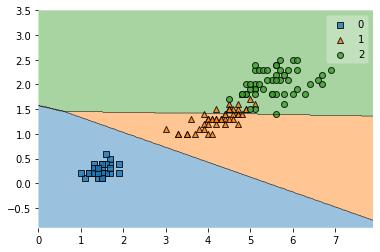

In [13]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
mymodel = ModelWrapper(model, device=torch.device('cpu'))
plot_decision_regions(X, y, mymodel)